# Modelos

In [1]:
MODEL_TYPES = ["rnn", "vggrnn", "transformer"]
TOKEN_TYPES = ["char", "bpe"]

MODELS_URLS = {
    "rnn_char" : "1c_J3MEEPQXhaYSYTMy-Pp6Wm7g4F3ppo",
    "vggrnn_char" : "12SAYVc8LMDEg9Hm5vcVnwIw_H1xqH8Dh",
    "transformer_char" : "1Sm_LZkna8RMCxWBCdoZwdPHecxJ5X24F",
    "rnn_bpe" : "18Ges8RBV5VOx1l7EuYUYrl4B7ikln4j-",
    "vggrnn_bpe" : "1A8sLkrP-Gl_BnQV0Nor5o46slmVHQE-t",
    "transformer_bpe" : "1EXhX_mvlZifFdxUXMlI4h-tTyqaJfZov"
}

## Instalação das dependências

In [2]:
!pip install torch
!pip install espnet==0.9.5

## Módulos, funções e classes para utilizar os modelos

In [3]:
import os
import io
import copy
import yaml
import torch
import shutil
import zipfile
import librosa
import numpy as np

from pathlib import Path
from os.path import abspath, join, exists, dirname, isfile, isdir
from typing import Tuple, Any, Dict, Union, TypeVar

from espnet2.tasks.asr import ASRTask
from espnet.nets.beam_search import BeamSearch
from espnet.nets.scorers.ctc import CTCPrefixScorer
from espnet2.torch_utils.device_funcs import to_device
from espnet.nets.scorers.length_bonus import LengthBonus
from espnet2.text.build_tokenizer import build_tokenizer
from espnet2.text.token_id_converter import TokenIDConverter
from espnet2.main_funcs.calculate_all_attentions import calculate_all_attentions

%matplotlib inline
import librosa.display
import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import Image, display, Audio

from google_drive_downloader import GoogleDriveDownloader as gdd


In [4]:
def download_model(model_type, token_type):
    if not model_type in MODEL_TYPES or not token_type in TOKEN_TYPES:
        raise ValueError(f"model_type '{model_type}' deve ser: {MODEL_TYPES} e token_type '{token_type}' deve ser: {TOKEN_TYPES}")
    else:
        fname = f"asr_train_commonvoice_{model_type}_raw_{token_type}_valid.acc.ave.zip"
        if not os.path.exists(fname):
            print(f"Downloading {fname}")
            gdd.download_file_from_google_drive(
                file_id=MODELS_URLS[f"{model_type}_{token_type}"],
                dest_path=f"./{fname}"
            )
        else:
            print(f"Model file {fname} already exists")
    return fname


In [5]:
class Result(object):
    def __init__(self) -> None:
        self.text = None
        self.tokens_txt = None
        self.tokens_int = None
        self.ctc_posteriors = None
        self.attention_weights = None
        self.encoded_vector = None
        self.audio_samples = None
        self.mel_features = None

class ASR(object):
    def __init__(
        self, 
        zip_model_file: Union[Path, str],
    ) -> None:
        
        self.zip_model_file = abspath(zip_model_file)
        self.device = 'cpu'
        self.model_config = self.extract_zip_model_file(self.zip_model_file)
        self.build_beam_search()
        self.build_tokenizer()

    def build_beam_search(self, ctc_weight: float = 0.4, beam_size: int = 1):
        """Constroi o objeto beam_search.

        Esse objeto faz a decodificação do vetor de embeddings da saída da parte encoder
        do modelo passando pelos decoders da rede que são o módulo CTC e Transformer ou RNN.

        Como:
        Loss = (1-λ)*DecoderLoss + λ*CTCLoss 
        Se ctc_weight=1 apenas o módulo CTC será usado na decodificação

        Args:
            ctc_weight (float, optional): Peso dado ao módulo CTC da rede. Defaults to 0.4.
            beam_size (int, optional): Tamanho do feixe de busca durante a codificação. Defaults to 1.
        """
        scorers = {}
        ctc = CTCPrefixScorer(ctc=self.model.ctc, eos=self.model.eos)
        token_list = self.model.token_list
        scorers.update(
            decoder=self.model.decoder,
            ctc=ctc,
            length_bonus=LengthBonus(len(token_list)),
        )

        #Variáveis com os pesos para cada parte da decodificação
        #lm referente à modelos de linguagem não são utilizados aqui mas são necessários no objeto
        weights = dict(
            decoder=1.0 - ctc_weight,
            ctc=ctc_weight,
            lm=1.0,
            length_bonus=0.0,
        )

        #Cria o objeto beam_search
        self.beam_search = BeamSearch(
            beam_size=beam_size,
            weights=weights,
            scorers=scorers,
            sos=self.model.sos,
            eos=self.model.eos,
            vocab_size=len(token_list),
            token_list=token_list,
            pre_beam_score_key=None if ctc_weight == 1.0 else "full",
        )

        self.beam_search.to(device=self.device, dtype=getattr(torch, 'float32')).eval()
        for scorer in scorers.values():
            if isinstance(scorer, torch.nn.Module):
                scorer.to(device=self.device, dtype=getattr(torch, 'float32')).eval()

    def build_tokenizer(self):
        """Cria um objeto tokenizer para conversão dos tokens inteiros para o dicionário
        de caracteres correspondente.

        Caso o modelo possua um modelo BPE de tokenização, ele é utilizado. Se não, apenas a lista
        de caracteres no arquivo de configuração é usada.
        """
        token_type = self.model_config['token_type']
        if token_type == 'bpe':
            bpemodel = self.model_config['bpemodel']
            self.tokenizer = build_tokenizer(token_type=token_type, bpemodel=bpemodel)
        else:
            self.tokenizer = build_tokenizer(token_type=token_type)
        
        self.converter = TokenIDConverter(token_list=self.model.token_list)


    def get_layers(self) -> Dict[str, Dict[str, torch.Size]]:
        """Retorna as camadas nomeadas e os respectivos shapes para todos os módulos da rede.

        Os módulos são:
            Encoder: RNN, VGGRNN, TransformerEncoder
            Decoder: RNN, TransformerDecoder
            CTC

        Returns:
            Dict[str, Dict[str, torch.Size]]: Dicionário de cada módulo com seus respectivos layers e shape
        """
        r = {}

        r['frontend'] = {x: self.model.frontend.state_dict()[x].shape 
                            for x in self.model.frontend.state_dict().keys()}
        r['specaug'] = {x: self.model.specaug.state_dict()[x].shape 
                            for x in self.model.specaug.state_dict().keys()}
        r['normalize'] = {x: self.model.normalize.state_dict()[x].shape 
                            for x in self.model.normalize.state_dict().keys()}
        r['encoder'] = {x: self.model.encoder.state_dict()[x].shape 
                            for x in self.model.encoder.state_dict().keys()}
        r['decoder'] = {x: self.model.decoder.state_dict()[x].shape 
                            for x in self.model.decoder.state_dict().keys()}
        r['ctc']     = {x: self.model.ctc.state_dict()[x].shape 
                            for x in self.model.ctc.state_dict().keys()}
        return r


    def frontend(self, audiofile: Union[Path, str, bytes], normalize: bool = True) -> Tuple[torch.Tensor, torch.Tensor]:
        """Executa o frontend do modelo, transformando as amostras de áudio em parâmetros log mel spectrogram

        Args:
            audiofile (Union[Path, str]): arquivo de áudio

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Parâmetros, Tamanho do vetor de parâmetros
        """
        if isinstance(audiofile, str):
            audio_samples, rate = librosa.load(audiofile, sr=16000)
        elif isinstance(audiofile, bytes):
            audio_samples, rate = librosa.core.load(io.BytesIO(audiofile), sr=16000)
        else:
            raise ValueError("Failed to load audio file")
            
        if isinstance(audio_samples, np.ndarray):
            audio_samples = torch.tensor(audio_samples)
        audio_samples = audio_samples.unsqueeze(0).to(getattr(torch, 'float32'))
        lengths = audio_samples.new_full([1], dtype=torch.long, fill_value=audio_samples.size(1))
        features, features_length  = self.model.frontend(audio_samples, lengths)

        if normalize:
            features, features_length = self.model.normalize(features, features_length)

        return features, features_length

    def specaug(self, features: torch.Tensor, features_length: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Executa o módulo specaug, da parte de 'data augmentation'.
        Útil para visualização apenas. 
        Não é utilizado na inferência, apenas no treinamento.

        Args:
            features (torch.Tensor): Parâmetros
            features_length (torch.Tensor): tamanho do vetor de parâmetros

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Parâmetros com máscaras temporais, em frequência e distoção. Tamanho dos vetores
        """
        return self.model.specaug(features, features_length)

    def extract_zip_model_file(self, zip_model_file: str) -> Dict[str, Any]:
        """Extrai os dados de um zip contendo o arquivo com o estado do modelo e configurações

        Args:
            zip_model_file (str): ZipFile do modelo gerado dos scripts de treinamento

        Raises:
            ValueError: Se o arquivo não for correto
            FileNotFoundError: Se o arquivo zip não contiver os arquivos necessários

        Returns:
            Dict[str, Any]: Dicionário do arquivo .yaml utilizado durante o treinamento para carregar o modelo corretamente
        """
        if not zipfile.is_zipfile(zip_model_file):
            raise ValueError(f"File {zip_model_file} is not a zipfile")
        else:
            zipfile.ZipFile(zip_model_file).extractall(dirname(zip_model_file))

        check = ['exp', 'meta.yaml']

        if not all([x for x in check]):
            raise FileNotFoundError
        
        with open('meta.yaml') as f:
            meta = yaml.load(f, Loader=yaml.FullLoader)

        model_stats_file = meta['files']['asr_model_file']
        asr_model_config_file = meta['yaml_files']['asr_train_config']
        
        asr_model_config = {}
        with open(asr_model_config_file) as f:
            asr_model_config = yaml.load(f, Loader=yaml.FullLoader)
            try:
                self.modelglobal_cmvn = asr_model_config['normalize_conf']['stats_file']
            except KeyError:
                self.global_cmvn = None

        print(f'Loading model config from {asr_model_config_file}')
        print(f'Loading model state from {model_stats_file}')

        #Build Model
        self.model, _ = ASRTask.build_model_from_file(
            asr_model_config_file, model_stats_file, self.device
        )
        self.model.to(dtype=getattr(torch, 'float32')).eval()

        return asr_model_config

    def __del__(self) -> None:
        """Remove os arquivos temporários
        """
        for f in ['exp', 'meta.yaml']:
            print(f"Removing {f}")
            ff = join(dirname(self.zip_model_file), f)
            if exists(ff):
                if isdir(ff):
                    shutil.rmtree(ff)
                elif isfile(ff):
                    os.remove(ff)
                else:
                    raise ValueError("Error ao remover arquivos temporários")
            

    @torch.no_grad()
    def recognize(self, audiofile: Union[Path, str, bytes]) -> Result:

        result = Result()
        
        if isinstance(audiofile, str):
            audio_samples, rate = librosa.load(audiofile, sr=16000)
        elif isinstance(audiofile, bytes):
            audio_samples, rate = librosa.core.load(io.BytesIO(audiofile), sr=16000)
        else:
            raise ValueError("Failed to load audio file")

        result.audio_samples = copy.deepcopy(audio_samples)

        #a entrada do modelo é torch.tensor
        if isinstance(audio_samples, np.ndarray):
            audio_samples = torch.tensor(audio_samples)
        audio_samples = audio_samples.unsqueeze(0).to(getattr(torch, 'float32'))
        
        lengths = audio_samples.new_full([1], dtype=torch.long, fill_value=audio_samples.size(1))
        batch = {"speech": audio_samples, "speech_lengths": lengths}
        batch = to_device(batch, device=self.device)

        #model encoder
        enc, _ = self.model.encode(**batch)

        #model decoder
        nbest_hyps = self.beam_search(x=enc[0])

        #Apenas a melhor hipótese
        best_hyps = nbest_hyps[0]

        #Conversão de tokenids do treinamento para texto
        token_int = best_hyps.yseq[1:-1].tolist()
        token_int = list(filter(lambda x: x != 0, token_int))
        token = self.converter.ids2tokens(token_int)
        text = self.tokenizer.tokens2text(token)

        #Preenche o objeto result
        result.text = text
        result.encoded_vector = enc[0] #[0] remove dimensão de batch
        
        #calcula todas as matrizes de atenção aij = softmax(QK/sqrt(d))*V
        #onde Q, K, V são transformações lineares y=wx+b
        #self attention: Q, K e V são os mesmos vetores
        #source attention: Q, K são o resultado do encoder e V o resultado do decoder a cada passo da decodificação
        text_tensor = torch.Tensor(token_int).unsqueeze(0).to(getattr(torch, 'long'))
        batch["text"] = text_tensor
        batch["text_lengths"] = text_tensor.new_full([1], dtype=torch.long, fill_value=text_tensor.size(1))
        
        result.attention_weights = calculate_all_attentions(self.model, batch)
        result.tokens_txt = token

        #CTC posteriors
        logp = self.model.ctc.log_softmax(enc.unsqueeze(0))[0]
        result.ctc_posteriors = logp.exp_().numpy()
        result.tokens_int = best_hyps.yseq
        result.mel_features, _ = self.frontend(audiofile, normalize=False)
        return result

    def __call__(self, input: Union[Path, str, bytes]) -> Result:
        return self.recognize(input)

asr = None

## Escolha um tipo de modelo

In [6]:
w1 = widgets.RadioButtons(
    options=MODEL_TYPES,
    value='rnn', # Defaults to 'pineapple'
    description='Model type:',
    disabled=False
)
display(w1)

RadioButtons(description='Model type:', options=('rnn', 'vggrnn', 'transformer'), value='rnn')

## Escolha um formato dos símbolos $Y$


In [7]:
w2 = widgets.RadioButtons(
    options=TOKEN_TYPES,
    value='char', # Defaults to 'pineapple'
    description='Token type:',
    disabled=False
)
display(w2)

RadioButtons(description='Token type:', options=('char', 'bpe'), value='char')

## Faça o upload de um arquivo de áudio para inferência (wav, 16KHz)


In [8]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

## Execute a célula abaixo para carregar o modelo selecionado e realizar a inferência do áudio

É possível alterar os modelos nos diálogos acima e executar apenas a célula abaixo para fazer uma nova inferência em um novo modelo. Para visualizar as figuras para o novo modelo, da mesma forma, basta executar as células abaixo.

In [9]:
if isinstance(asr, ASR):
    del asr
    asr = None

model_type = w1.value
token_type = w2.value
try: 
    audio_file = uploader.value[list(uploader.value.keys())[0]]['content']
except IndexError:
    raise ValueError("Faça o upload de um arquivo de áudio")
    
model_file = download_model(model_type, token_type)

asr = ASR(model_file)

results = asr.recognize(audio_file)

#print("Ref: pesquisa é uma coisa que muda toda hora")
print(f"Hypotese: {results.text}")


Model file asr_train_commonvoice_rnn_raw_char_valid.acc.ave.zip already exists
Loading model config from exp/asr_train_commonvoice_rnn_raw_char/config.yaml
Loading model state from exp/asr_train_commonvoice_rnn_raw_char/valid.acc.ave_5best.pth
Hypotese: pesquisa é uma coisa que muda toda a hora


## Descrição do modelo

In [10]:
asr.model

ESPnetASRModel(
  (frontend): DefaultFrontend(
    (stft): Stft(n_fft=512, win_length=512, hop_length=128, center=True, normalized=False, onesided=True)
    (frontend): Frontend()
    (logmel): LogMel(sr=16000, n_fft=512, n_mels=80, fmin=0, fmax=8000.0, htk=False)
  )
  (specaug): SpecAug(
    (time_warp): TimeWarp(window=5, mode=bicubic)
    (freq_mask): MaskAlongAxis(mask_width_range=[0, 30], num_mask=2, axis=freq)
    (time_mask): MaskAlongAxis(mask_width_range=[0, 40], num_mask=2, axis=time)
  )
  (normalize): GlobalMVN(stats_file=exp/asr_stats_raw_char/train/feats_stats.npz, norm_means=True, norm_vars=True)
  (encoder): RNNEncoder(
    (enc): ModuleList(
      (0): RNNP(
        (birnn0): LSTM(80, 1024, batch_first=True, bidirectional=True)
        (bt0): Linear(in_features=2048, out_features=1024, bias=True)
        (birnn1): LSTM(1024, 1024, batch_first=True, bidirectional=True)
        (bt1): Linear(in_features=2048, out_features=1024, bias=True)
        (birnn2): LSTM(1024, 10

## Camadas do modelo

In [11]:
asr.get_layers()

{'frontend': {'logmel.melmat': torch.Size([257, 80])},
 'specaug': {},
 'normalize': {'mean': torch.Size([80]), 'std': torch.Size([80])},
 'encoder': {'enc.0.birnn0.weight_ih_l0': torch.Size([4096, 80]),
  'enc.0.birnn0.weight_hh_l0': torch.Size([4096, 1024]),
  'enc.0.birnn0.bias_ih_l0': torch.Size([4096]),
  'enc.0.birnn0.bias_hh_l0': torch.Size([4096]),
  'enc.0.birnn0.weight_ih_l0_reverse': torch.Size([4096, 80]),
  'enc.0.birnn0.weight_hh_l0_reverse': torch.Size([4096, 1024]),
  'enc.0.birnn0.bias_ih_l0_reverse': torch.Size([4096]),
  'enc.0.birnn0.bias_hh_l0_reverse': torch.Size([4096]),
  'enc.0.bt0.weight': torch.Size([1024, 2048]),
  'enc.0.bt0.bias': torch.Size([1024]),
  'enc.0.birnn1.weight_ih_l0': torch.Size([4096, 1024]),
  'enc.0.birnn1.weight_hh_l0': torch.Size([4096, 1024]),
  'enc.0.birnn1.bias_ih_l0': torch.Size([4096]),
  'enc.0.birnn1.bias_hh_l0': torch.Size([4096]),
  'enc.0.birnn1.weight_ih_l0_reverse': torch.Size([4096, 1024]),
  'enc.0.birnn1.weight_hh_l0_rever

## Inferência

Hypotese: pesquisa é uma coisa que muda toda a hora


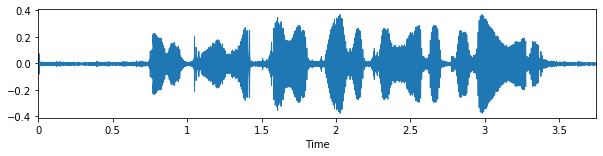

In [12]:
#Audio
plt.figure(figsize=(10, 2))
librosa.display.waveplot(results.audio_samples, sr=16000)
print(f"Hypotese: {results.text}")
Audio(audio_file)

## Parâmetros mel-fbank (dim=80)

(frontend): DefaultFrontend(

    (stft): Stft(n_fft=512, win_length=512, hop_length=128, center=True, normalized=False, onesided=True)
    
    (frontend): Frontend()
    
    (logmel): LogMel(sr=16000, n_fft=512, n_mels=80, fmin=0, fmax=8000.0, htk=False)
    
 )

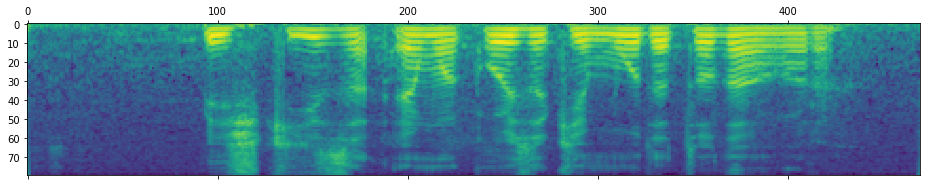

In [13]:
plt.matshow(results.mel_features[0].T)

## Specaug

Data augmentation utilizada durante o treinamento, aqui mostrada apenas para visualização.
Máscaras no tempo e na frequência, além de time warping são aplicadas aleatoriamente. É possível executar a célula abaixo várias vezes para visualizar diferentes resultados.

(specaug): [SpecAug](https://arxiv.org/pdf/1904.08779)(

    (time_warp): TimeWarp(window=5, mode=bicubic)
    
    (freq_mask): MaskAlongAxis(mask_width_range=[0, 30], num_mask=2, axis=freq)
    
    (time_mask): MaskAlongAxis(mask_width_range=[0, 40], num_mask=2, axis=time)
    
 )

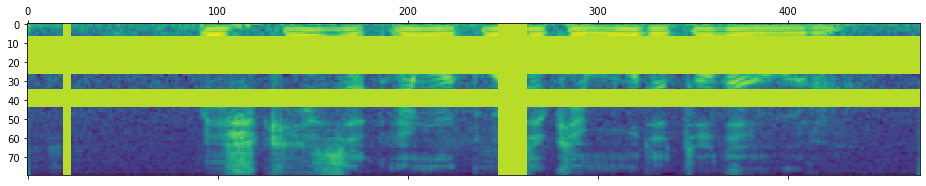

In [14]:
specaug_features,_ = asr.specaug(results.mel_features, results.mel_features.shape[1:])
plt.matshow(specaug_features[0].T)
#specaug_features = ASR.model.specaug(results.mel_features, results.mel_features.shape)

## Resultado da camada Encoder

Diferentes redes de encoder fazem diferentes tipos de transformação dos atributos de entrada $\mathbf{X}$. O vetor enc tem diferentes dimensões em cada um deles.

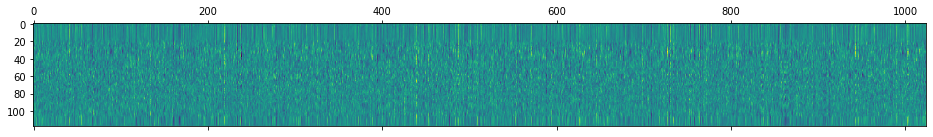

In [15]:
enc = results.encoded_vector
plt.matshow(enc.detach().numpy())

## Visualização das matrizes de atenção

Cada modelo possui diferentes subcamadas de atenção, utiliza o menu abaixo para selecionar. O modelo transformer, baseado em Multihead attention e treinado com 8 heads mostra apenas a primeira delas, mas contém as 12 camadas do encoder e as 6 camadas do decoder

In [16]:
%pylab inline
from ipywidgets import interact, interactive, Layout
def f(x):
    attn = results.attention_weights[x][0]
    if len(attn.shape) == 3:
        attn = attn[0]
    fig, ax = plt.subplots(1, figsize=(10, 5))
    ax.set_title(f"Attention {x}")
    im = ax.matshow(attn, aspect="auto")
    fig.colorbar(im)
    if not 'self_attn' in x or not 'encoder.encoders' in x:
        ax.set_yticks(range(len(results.tokens_txt)))
        ax.set_yticklabels(results.tokens_txt)
    fig.tight_layout()

int_widget = interactive(f, x=list(results.attention_weights.keys()))
#int_widget.children[0].layout = Layout(width='100px')
display(int_widget)

Populating the interactive namespace from numpy and matplotlib


/home/aluca/espnet_projeto/tools/venv_projeto/envs/venv_projeto/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


interactive(children=(Dropdown(description='x', options=('decoder.att_list.0',), value='decoder.att_list.0'), …

## Visualização dos CTC Posteriors

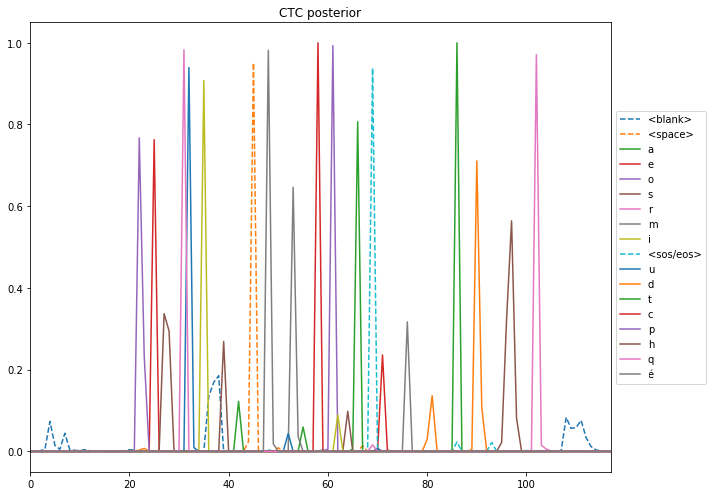

In [17]:
prob = results.ctc_posteriors[0]
fig, ax = plt.subplots(1, figsize=(10, 7))
ax.set_title("CTC posterior")
vs = set(results.tokens_int.tolist())
vs.add(0)
for n, i in enumerate(vs):
    v = asr.converter.ids2tokens([i])[0]
    ax.plot(prob[:, i], label=v, linestyle="-" if len(v) == 1 else "--")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim(0, len(results.encoded_vector)-1)
fig.tight_layout()


## 1 A Tarefa ASR




## 2 Os Conjuntos de dados
### 2.1 Alcaim
### 2.2 LapsBM
### 2.3 Sid
### 2.4 Voxforge
### 2.5 CommonVoice
### 2.6 Explorando os dados


## 3 Os atributos
### 3.1 Fbank (audio -> window -> torch.stft -> librosa.filters.mel * stft -> log (log-mel-fbank) )
### 3.2 Cepstral mean and variance normalization/subtraction ("transformação de atributos")
### 3.3 Data Augmentation
#### 3.3.1 Specaug (time_warp, freq_mask, time_mask)


## 4 O Modelo
### 4.1 Multitask Learning (Hybrid CTC attention)
### 4.2 Encoder RNN
#### 4.2.1 Encoder RNN (BiLSTMP)
#### 4.2.2 Encoder VGG(like) RNN (BiLSTMP)
### 4.3 Decoder RNN
#### 4.3.1 Decoder RNN (BiLSTMP + attn)
### 4.4 Transformer
### 4.4.1 Transformer Encoder
#### 4.4.1.1 Selfattention
#### 4.4.1.2 Multihead Attention
### 4.4.2 Transformer Decoder
### 4.5 CTC Connectionist temporal Classification
#### 4.5.1 CTC Loss
##### 4.5.1.1 Trellis, Dynamic Programming
### 4.6 Subword tokenization (modelo char, bpe)


## 4 Treinamentos
### 4.1 Encoder RNN (BiLSTMP), Decoder RNN (BiLSTMP+attn type DotProd) mais CTC
#### 4.1.1 char
#### 4.1.2 bpe
### 4.2 Encoder VGG(like)+RNN (BiLSTMP), Decoder RNN (BiLSTMP+attn) mais CTC
#### 4.2.1 char
#### 4.2.2 bpe
### 4.3 Encoder Transformer, Decoder Transformer (attn type: DotProd Multihead) mais CTC
#### 4.3.1 char
#### 4.3.2 bpe


## 5 Exemplo step-by-step
### 5.1 Carrega Audio
### 5.2 Extrai Features
### 5.3 O vetor de embeddings
### 5.4 Attention Weights
### 5.5 CTC Posteriors
### 5.6 BeamSearch, Hipoteses e Resultados

## 6 Considerações







## 1 A Tarefa ASR

Donec iaculis quam rhoncus lorem dignissim venenatis. Morbi metus odio, ornare a dui sed, volutpat malesuada eros. Curabitur sit amet pellentesque eros, nec lacinia sem. Pellentesque vulputate, mauris ac sollicitudin efficitur, ante lacus auctor arcu, sit amet suscipit ligula nunc fringilla dolor. Donec sit amet neque eget nisi posuere blandit vitae ac ante. Nulla leo ipsum, hendrerit in enim at, pharetra posuere quam. Suspendisse luctus varius dui id pellentesque. Nam tincidunt volutpat turpis, ut commodo magna efficitur ac. Ut ornare ante id nibh bibendum, a semper ipsum condimentum. Sed vitae sollicitudin felis. Sed eget ante aliquam, fermentum felis auctor, vestibulum ipsum. Nam gravida libero vitae mi accumsan tempor. Nullam placerat sed metus imperdiet lobortis. Curabitur bibendum est dolor, nec lobortis odio vehicula a.


## 2 Os Conjuntos de dados

### 2.1 Alcaim

### 2.1.1 Explorando os dados
    Mostrar histogramas de duração dos trechos
    Mostrar histogramas de caracteres ou BPE (talvez não)

### 2.2 LapsBM

### 2.2.1 Explorando os dados
    Mostrar histogramas de duração dos trechos
    Mostrar histogramas de caracteres ou BPE (talvez não)

### 2.3 Sid

### 2.3.1 Explorando os dados
    Mostrar histogramas de duração dos trechos
    Mostrar histogramas de caracteres ou BPE (talvez não)

### 2.4 Voxforge

### 2.4.1 Explorando os dados
    Mostrar histogramas de duração dos trechos
    Mostrar histogramas de caracteres ou BPE (talvez não)

### 2.5 CommonVoice

### 2.5.1 Explorando os dados
    Mostrar histogramas de duração dos trechos
    Mostrar histogramas de caracteres ou BPE (talvez não)



## 3 Os atributos

Vivamus rhoncus vitae enim a rutrum. Curabitur porta dolor nec egestas auctor. Mauris luctus arcu et purus pharetra euismod. Aliquam porttitor felis risus, et sollicitudin magna sodales a. Etiam turpis massa, bibendum nec gravida in, elementum et elit. In tortor mi, rutrum eget nisl sit amet, pharetra cursus nisi. In dignissim, nunc sed ultrices mollis, felis nisl ultricies urna, at efficitur dui lectus et nisi. Vivamus quis ornare mi. Duis massa mauris, tempor sit amet bibendum quis, fermentum eget nisi.


### 3.1 Fbank

Vivamus rhoncus vitae enim a rutrum. Curabitur porta dolor nec egestas auctor. Mauris luctus arcu et purus pharetra euismod. Aliquam porttitor felis risus, et sollicitudin magna sodales a. Etiam turpis massa, bibendum nec gravida in, elementum et elit. In tortor mi, rutrum eget nisl sit amet, pharetra cursus nisi. In dignissim, nunc sed ultrices mollis, felis nisl ultricies urna, at efficitur dui lectus et nisi. Vivamus quis ornare mi. Duis massa mauris, tempor sit amet bibendum quis, fermentum eget nisi.




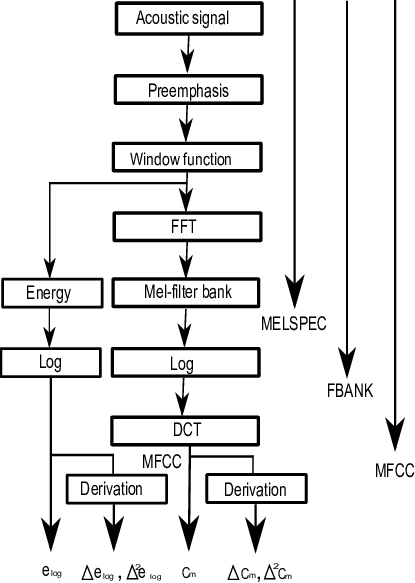

In [3]:
Image("img/features.png")

### 3.2 Pitch

https://danielpovey.com/files/2014_icassp_pitch.pdf

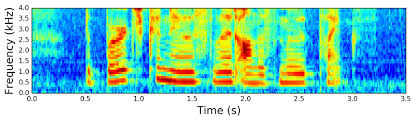

In [4]:
Image("img/featured_signal.jpg")

### 3.3 Data Augmentation

#### 3.3.1 Specaug
https://arxiv.org/pdf/1904.08779

Vivamus rhoncus vitae enim a rutrum. Curabitur porta dolor nec egestas auctor. Mauris luctus arcu et purus pharetra euismod. Aliquam porttitor felis risus, et sollicitudin magna sodales a. Etiam turpis massa, bibendum nec gravida in, elementum et elit. In tortor mi, rutrum eget nisl sit amet, pharetra cursus nisi. In dignissim, nunc sed ultrices mollis, felis nisl ultricies urna, at efficitur dui lectus et nisi. Vivamus quis ornare mi. Duis massa mauris, tempor sit amet bibendum quis, fermentum eget nisi.



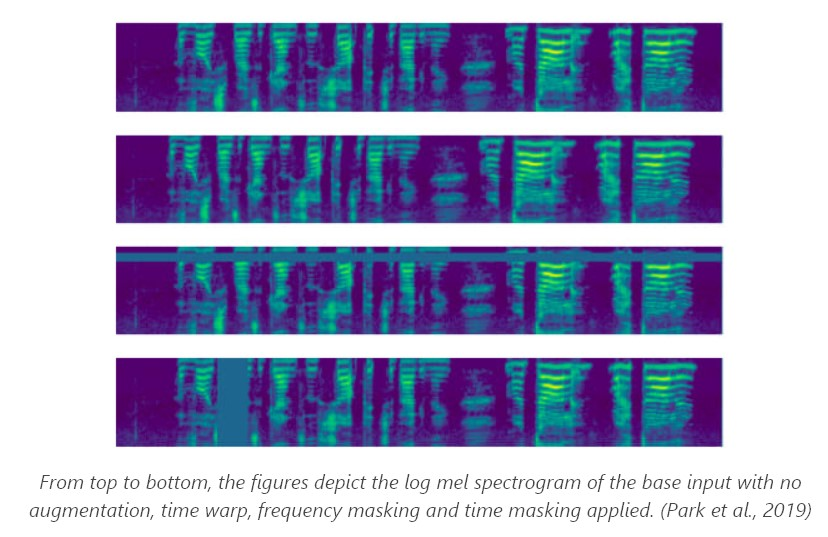

In [5]:
Image("img/specaug.jpg")

#### 3.3.2 Speed Perturbation

Maecenas sed nulla at ex scelerisque commodo a nec diam. Suspendisse pulvinar maximus odio, eu rhoncus dolor aliquet ornare. Nullam convallis quam a ipsum ultrices aliquet. Maecenas ut augue a eros mattis dictum vitae eget metus. Ut posuere elit vel dui aliquam scelerisque. Etiam fermentum enim at luctus consectetur. Morbi id molestie odio.



### 3.4 Raw Audio (ESPNet Frontend (mel scale fbank sem pitch))

ESPNet Frontend
- Domain-conversion: e.g. Stft: time -> time-freq
        
- STFT -> Power spectrum refers to the real/imag parts of Complex

- Feature transform e.g. Stft -> Log-Mel-Fbank = librosa.filters.mel(real(stft)**2+imag(stft)**2)



## 4 O Modelo

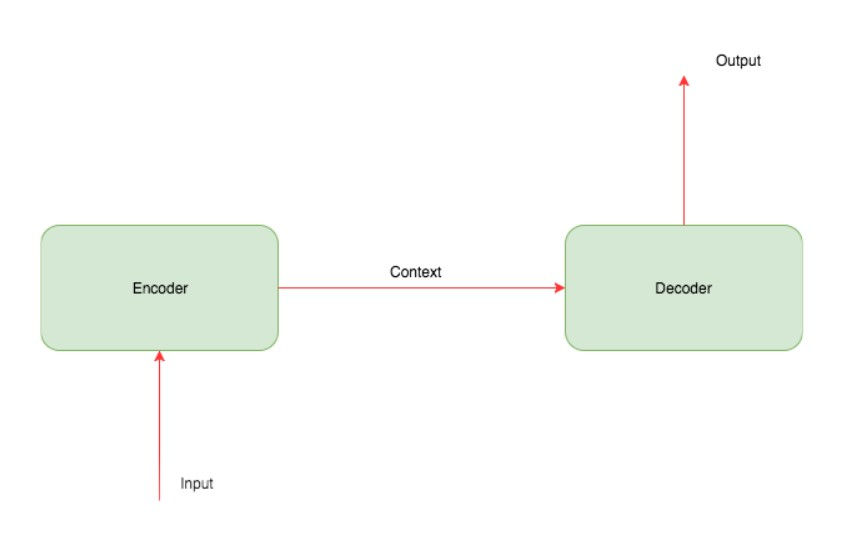

In [10]:
Image("img/encoder_decoder.jpg")

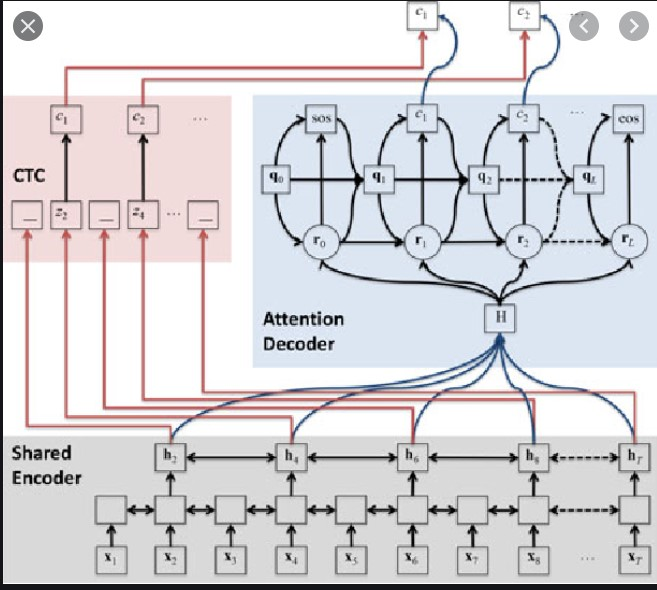

In [16]:
Image("img/hybrid_ctc_attn.jpg")

### 4.1 Encoder

Pellentesque vestibulum justo nisl, at consectetur magna ultrices iaculis. Cras quis nunc accumsan, consectetur dolor eleifend, condimentum dolor. Phasellus accumsan ullamcorper est, quis tempor ipsum lacinia non. Suspendisse potenti. Donec iaculis quam finibus, fringilla risus vestibulum, consequat dui. Phasellus fringilla augue at urna pharetra venenatis. Aliquam tempor sagittis est, et feugiat velit. Proin molestie, nulla ac rhoncus venenatis, orci nisi sollicitudin risus, finibus semper dui ex eu leo.


#### 4.1.1 Encoder RNN

Donec iaculis quam rhoncus lorem dignissim venenatis. Morbi metus odio, ornare a dui sed, volutpat malesuada eros. Curabitur sit amet pellentesque eros, nec lacinia sem. Pellentesque vulputate, mauris ac sollicitudin efficitur, ante lacus auctor arcu, sit amet suscipit ligula nunc fringilla dolor. Donec sit amet neque eget nisi posuere blandit vitae ac ante. Nulla leo ipsum, hendrerit in enim at, pharetra posuere quam. Suspendisse luctus varius dui id pellentesque. Nam tincidunt volutpat turpis, ut commodo magna efficitur ac. Ut ornare ante id nibh bibendum, a semper ipsum condimentum. Sed vitae sollicitudin felis. Sed eget ante aliquam, fermentum felis auctor, vestibulum ipsum. Nam gravida libero vitae mi accumsan tempor. Nullam placerat sed metus imperdiet lobortis. Curabitur bibendum est dolor, nec lobortis odio vehicula a.



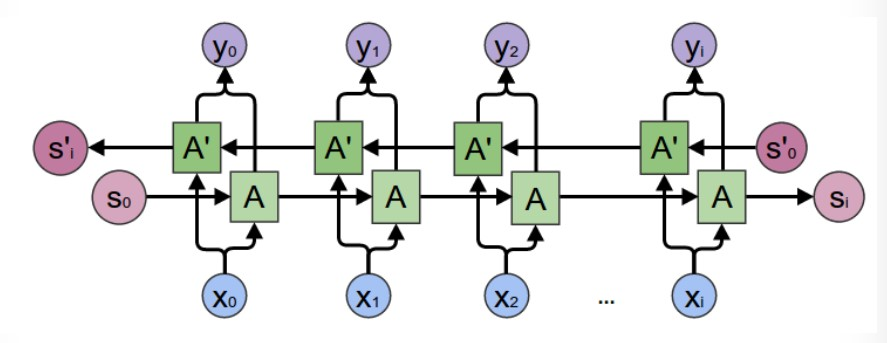

In [11]:
Image("img/bilstm.jpg")

#### 4.1.2 Encoder VGGLike+RNN

Vivamus rhoncus vitae enim a rutrum. Curabitur porta dolor nec egestas auctor. Mauris luctus arcu et purus pharetra euismod. Aliquam porttitor felis risus, et sollicitudin magna sodales a. Etiam turpis massa, bibendum nec gravida in, elementum et elit. In tortor mi, rutrum eget nisl sit amet, pharetra cursus nisi. In dignissim, nunc sed ultrices mollis, felis nisl ultricies urna, at efficitur dui lectus et nisi. Vivamus quis ornare mi. Duis massa mauris, tempor sit amet bibendum quis, fermentum eget nisi.



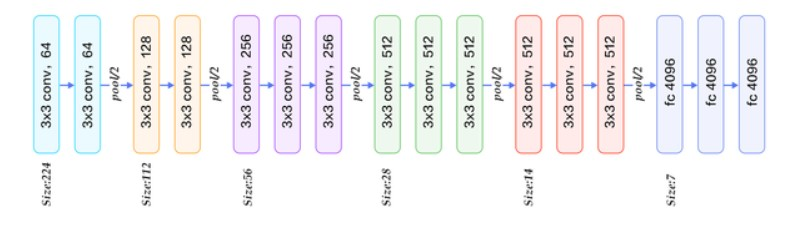

In [12]:
Image("img/vgg.jpg")

#### 4.1.3 Encoder Transformer

Phasellus congue mi in ante tempor convallis. Proin condimentum pellentesque lacus, vitae egestas sem pulvinar vitae. Morbi eu neque ut erat ullamcorper elementum. Fusce vel ipsum leo. Interdum et malesuada fames ac ante ipsum primis in faucibus. Maecenas eget placerat augue, sit amet dictum risus. Quisque gravida tellus sit amet quam ultricies, vel scelerisque dui sollicitudin.



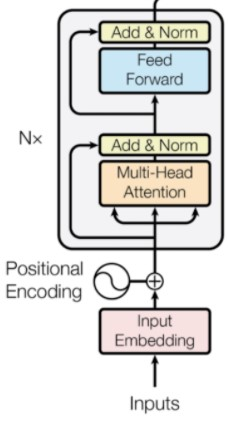

In [4]:
Image("img/img_encoder_transformer.jpg")

### 4.2 Decoder

Morbi quis est accumsan, semper quam in, dapibus est. Mauris quis egestas quam. Morbi vestibulum elit nec lectus vestibulum condimentum. Duis finibus lectus sed venenatis mattis. Sed in feugiat felis, ut semper diam. Suspendisse tincidunt sit amet justo nec fermentum. Nam eleifend ante sed leo blandit, a aliquam tortor venenatis. Pellentesque tristique porta lorem et sollicitudin.



#### 4.2.1 Decoder RNN+att

Vivamus rhoncus vitae enim a rutrum. Curabitur porta dolor nec egestas auctor. Mauris luctus arcu et purus pharetra euismod. Aliquam porttitor felis risus, et sollicitudin magna sodales a. Etiam turpis massa, bibendum nec gravida in, elementum et elit. In tortor mi, rutrum eget nisl sit amet, pharetra cursus nisi. In dignissim, nunc sed ultrices mollis, felis nisl ultricies urna, at efficitur dui lectus et nisi. Vivamus quis ornare mi. Duis massa mauris, tempor sit amet bibendum quis, fermentum eget nisi.



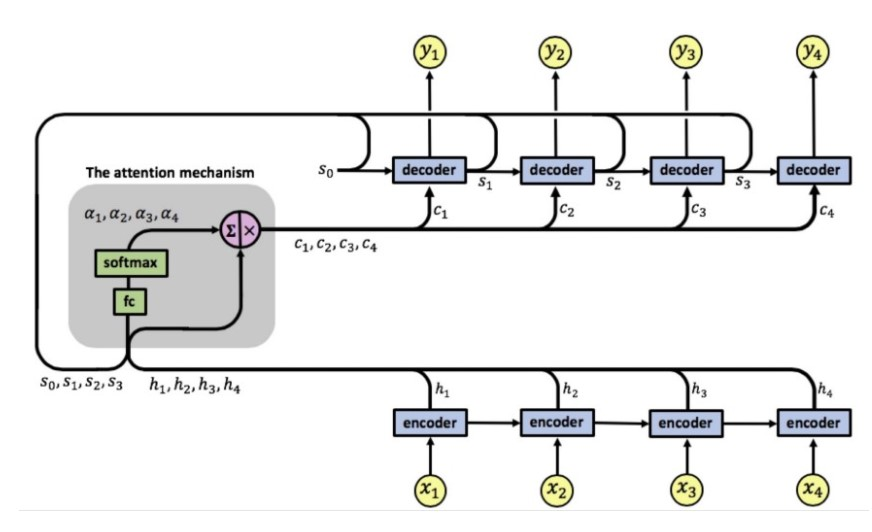

In [14]:
Image("img/rnn_att.jpg")

#### 4.2.2 Decoder Transformer

Morbi quis est accumsan, semper quam in, dapibus est. Mauris quis egestas quam. Morbi vestibulum elit nec lectus vestibulum condimentum. Duis finibus lectus sed venenatis mattis. Sed in feugiat felis, ut semper diam. Suspendisse tincidunt sit amet justo nec fermentum. Nam eleifend ante sed leo blandit, a aliquam tortor venenatis. Pellentesque tristique porta lorem et sollicitudin.




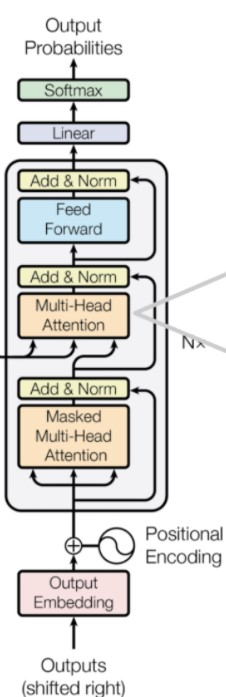

In [13]:
Image("img/img_decoder_transformer.jpg")

### 4.3 CTC Connectionist temporal Classification

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Fusce vitae hendrerit est, ut maximus dui. Vivamus at eros sapien. Nullam tempus nunc a odio faucibus, nec mollis arcu accumsan. Pellentesque nec congue mauris, ac pretium purus. Pellentesque fringilla dignissim mollis. In eu congue lacus. Donec finibus risus vitae condimentum euismod. Aenean vitae viverra augue. Sed vel semper tellus, sed molestie sapien. Lorem ipsum dolor sit amet, consectetur adipiscing elit. Maecenas id ipsum vestibulum, ultrices sapien id, dapibus dui. Class aptent taciti sociosqu ad litora torquent per conubia nostra, per inceptos himenaeos. Praesent ut semper nisi, malesuada egestas est. Mauris nec eros nulla.



#### 4.3.1 BILSTM

Morbi quis est accumsan, semper quam in, dapibus est. Mauris quis egestas quam. Morbi vestibulum elit nec lectus vestibulum condimentum. Duis finibus lectus sed venenatis mattis. Sed in feugiat felis, ut semper diam. Suspendisse tincidunt sit amet justo nec fermentum. Nam eleifend ante sed leo blandit, a aliquam tortor venenatis. Pellentesque tristique porta lorem et sollicitudin.



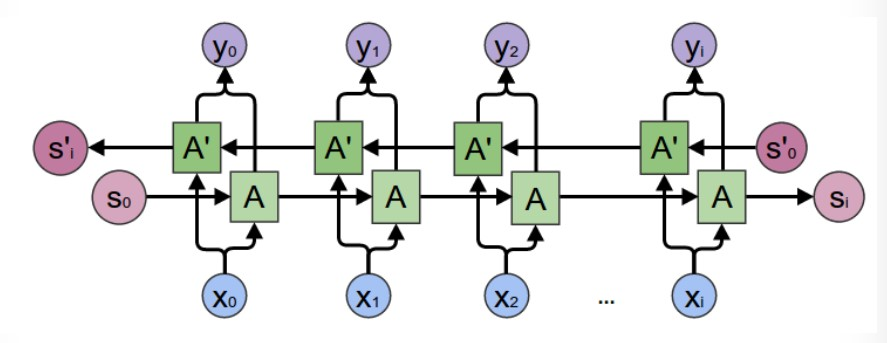

In [5]:
Image("img/bilstm.jpg")

#### 4.3.2 CTC Loss

Maecenas sed nulla at ex scelerisque commodo a nec diam. Suspendisse pulvinar maximus odio, eu rhoncus dolor aliquet ornare. Nullam convallis quam a ipsum ultrices aliquet. Maecenas ut augue a eros mattis dictum vitae eget metus. Ut posuere elit vel dui aliquam scelerisque. Etiam fermentum enim at luctus consectetur. Morbi id molestie odio.



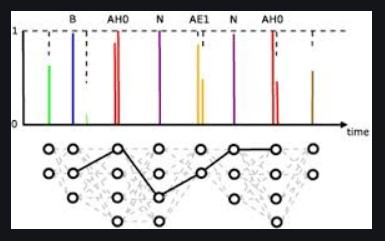

In [9]:
Image("img/ctc_loss.jpg")

##### 4.3.2.1 Trellis

Etiam faucibus, mauris nec luctus commodo, lectus lectus porta mauris, sed auctor turpis purus sagittis nunc. Aliquam risus nisi, dapibus a velit eget, luctus facilisis urna. Proin a lorem orci. Duis eu fringilla erat. Nunc non eleifend nibh, vulputate dignissim odio. Suspendisse potenti. Praesent ut condimentum lectus. Nulla facilisi. Aliquam quis est eleifend, imperdiet purus auctor, dapibus sem. Morbi ac ornare nulla, pharetra venenatis est. Mauris lobortis urna lorem, dictum faucibus erat consequat a. Nam faucibus, elit eget varius finibus, ex mauris viverra justo, a imperdiet urna arcu eget dolor. Praesent quis odio enim. Fusce tristique maximus arcu, vel posuere purus consectetur eu.

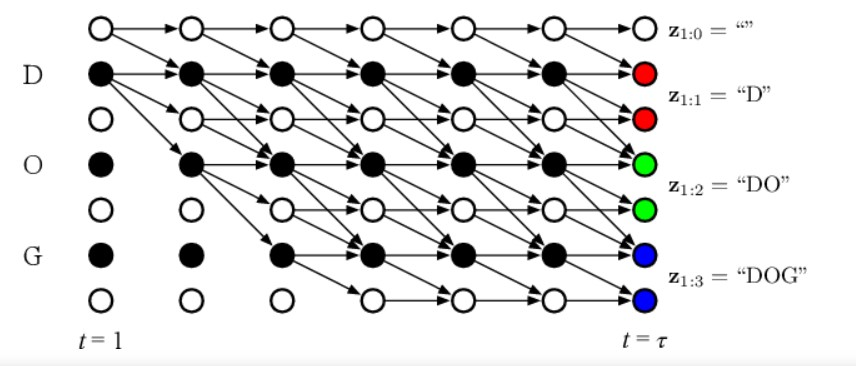

In [6]:
Image("img/trellis.jpg")

##### 4.3.2.2 Dynamic Programming

Pellentesque habitant morbi tristique senectus et netus et malesuada fames ac turpis egestas. Etiam at ornare sem. Nullam tincidunt vestibulum justo hendrerit consectetur. Vestibulum congue quam est, ut venenatis massa dictum sit amet. Etiam id blandit leo, laoreet consectetur nisl. Nullam suscipit, risus in aliquam aliquam, metus eros congue massa, ac porttitor quam tellus quis nunc. Vestibulum ante ipsum primis in faucibus orci luctus et ultrices posuere cubilia curae; Vivamus porta volutpat faucibus. Curabitur sem eros, tristique et lectus sed, venenatis bibendum orci. Fusce imperdiet at eros at molestie.


(https://m.blog.naver.com/sogangori/221183469708)

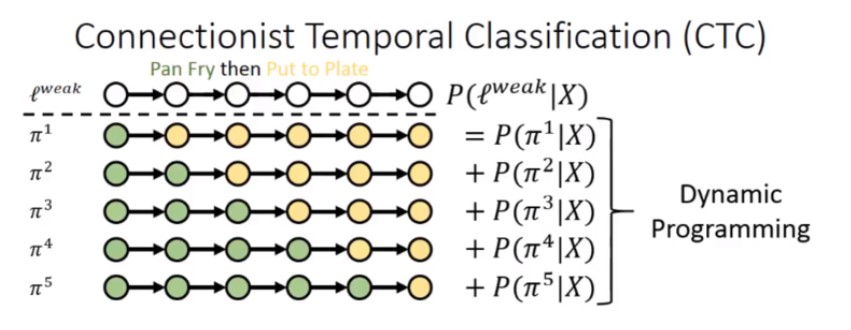

In [7]:
Image("img/dynamic_programming_ctc.jpg")

### 4.4 Attention

Etiam faucibus, mauris nec luctus commodo, lectus lectus porta mauris, sed auctor turpis purus sagittis nunc. Aliquam risus nisi, dapibus a velit eget, luctus facilisis urna. Proin a lorem orci. Duis eu fringilla erat. Nunc non eleifend nibh, vulputate dignissim odio. Suspendisse potenti. Praesent ut condimentum lectus. Nulla facilisi. Aliquam quis est eleifend, imperdiet purus auctor, dapibus sem. Morbi ac ornare nulla, pharetra venenatis est. Mauris lobortis urna lorem, dictum faucibus erat consequat a. Nam faucibus, elit eget varius finibus, ex mauris viverra justo, a imperdiet urna arcu eget dolor. Praesent quis odio enim. Fusce tristique maximus arcu, vel posuere purus consectetur eu.


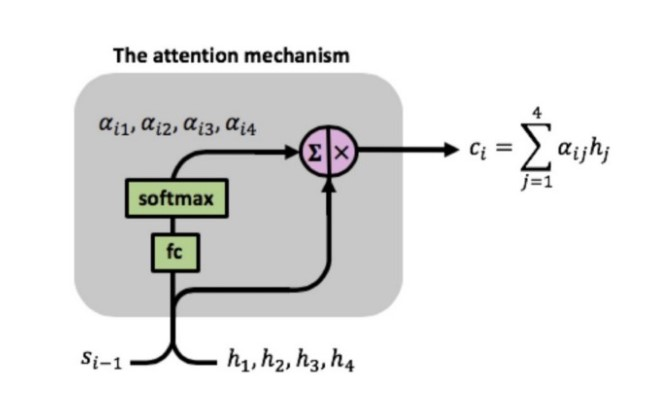

In [15]:
Image("img/attn.jpg")

#### 4.4.1 Transformer attention

Morbi quis est accumsan, semper quam in, dapibus est. Mauris quis egestas quam. Morbi vestibulum elit nec lectus vestibulum condimentum. Duis finibus lectus sed venenatis mattis. Sed in feugiat felis, ut semper diam. Suspendisse tincidunt sit amet justo nec fermentum. Nam eleifend ante sed leo blandit, a aliquam tortor venenatis. Pellentesque tristique porta lorem et sollicitudin.


##### 4.4.1.1 Dot Product Attention

Maecenas sed nulla at ex scelerisque commodo a nec diam. Suspendisse pulvinar maximus odio, eu rhoncus dolor aliquet ornare. Nullam convallis quam a ipsum ultrices aliquet. Maecenas ut augue a eros mattis dictum vitae eget metus. Ut posuere elit vel dui aliquam scelerisque. Etiam fermentum enim at luctus consectetur. Morbi id molestie odio.


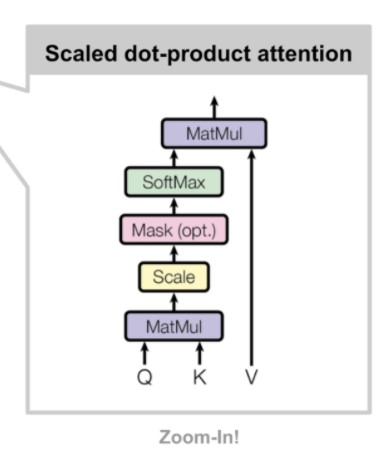

In [17]:
Image("img/img_dot_prod_attn.jpg")

##### 4.4.1.2 Multihead Attention

Vivamus rhoncus vitae enim a rutrum. Curabitur porta dolor nec egestas auctor. Mauris luctus arcu et purus pharetra euismod. Aliquam porttitor felis risus, et sollicitudin magna sodales a. Etiam turpis massa, bibendum nec gravida in, elementum et elit. In tortor mi, rutrum eget nisl sit amet, pharetra cursus nisi. In dignissim, nunc sed ultrices mollis, felis nisl ultricies urna, at efficitur dui lectus et nisi. Vivamus quis ornare mi. Duis massa mauris, tempor sit amet bibendum quis, fermentum eget nisi.



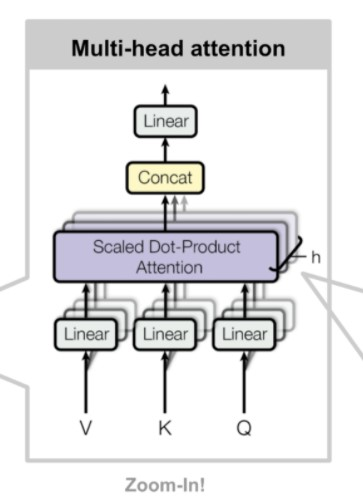

In [18]:
Image("img/img_mha.jpg")

## 5 Treinamentos

Falar sobre todos os treinamentos de todos os conjuntos de dados, mostrar as figuras de acc, loss, loss_att, loss_ctc, e resultados (pegar tudo do tensorboard e dos logs do espnet)

Minhas sugestões (Andre)

Treinamentos com todos os conjuntos de dados (talvez exceto o alcaim) os modelos descritos acima (RNN, VGGRNN e Transformer)

Treinar todas essas opções de modelo+dataset com as features extraídas do kaldi, com raw_audio e com o frontend do espnet (que usa seu proprio fbank e nao usa o parâmetro pitch)
        
        

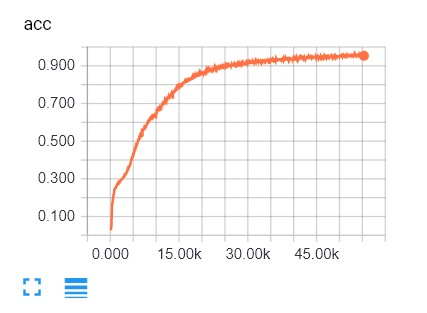

In [23]:
Image("img/acc_exemplo.jpg")

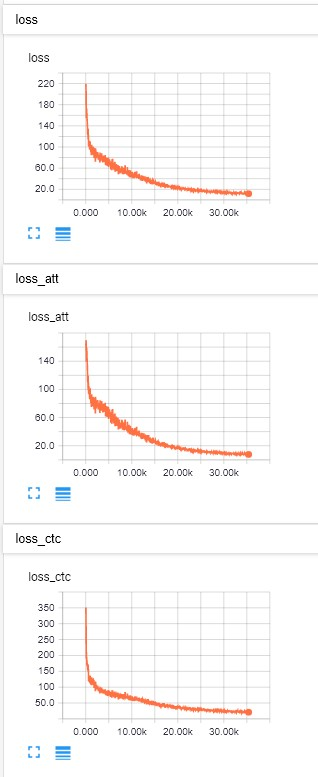

In [24]:
Image("img/loss_exemplo.jpg")

## 5 Exemplo step-by-step

In [ ]:
#a classe ASRDecoder talvez seja parecida com isso
fbank_pitch = asr_decoder.extract_fbank_pitch(audiofile)
fbank_pitch.shape

batch_fbank_pitch = asr_decoder.batchfy(fbank_pitch)

encoded = asr_decoder.encode(batch_fbank_pitch)

hypothesis = asr_decoder.beam_search(encoded)

asr_decoder.plot_ctc(encoded)

asr_decoder.plot_all_attentions(encoded)

### 5.1 Carrega Audio

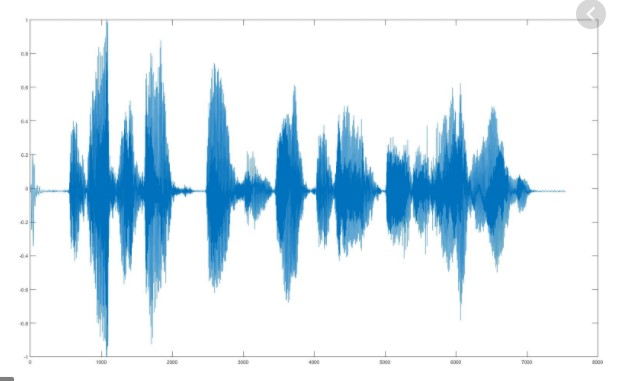

In [26]:
Image("img/audio_signal.jpg")

### 5.2 Extrai Features

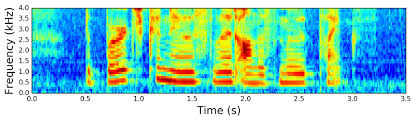

In [27]:
Image("img/featured_signal.jpg")

### 5.3 Mostrar o vetor de embeddings

### 5.4 Attention Weights


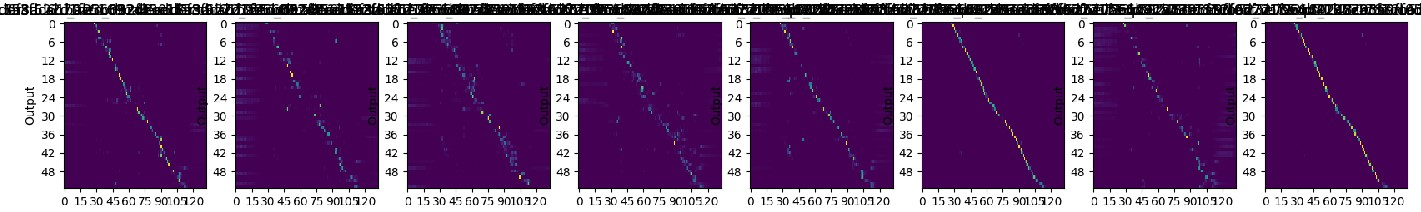

In [28]:
Image("img/att_ws.jpg")

### 5.5 CTC Posteriors



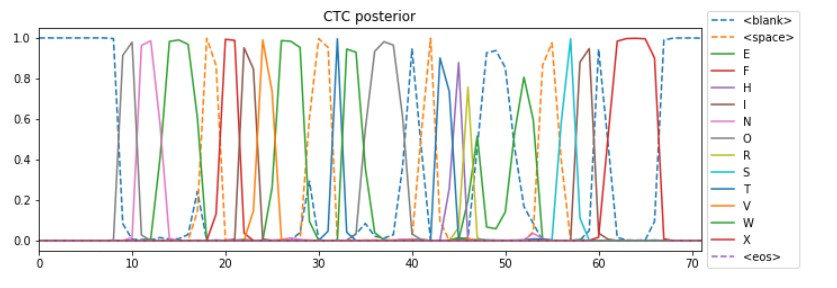

In [29]:
Image("img/ctc_posteriors.jpg")

### 5.6 BeamSearch, Hipoteses e Resultados

##  6 Considerações

### 6.1 Complexidade O(n2) no decoder transformer

### 6.2 Qualquer outra coisa